#Step 1: Environment preparation

##Libraries

In [ ]:
%load_ext tensorboard

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import datetime
import time

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow import keras
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report

from sklearn.metrics import f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

##Import CSV

In [ ]:
df = pd.read_csv("got.csv")

##Explore the Dataset

In [ ]:
print(df.head())
print(df.tail())
print("---------------------------------------------------------------------------------------------")
print(df.info())
print("---------------------------------------------------------------------------------------------")
print(df.describe())

   S.No  actual  pred  alive   plod                  name  \
0     1       0     0  0.054  0.946  Viserys II Targaryen   
1     2       1     0  0.387  0.613           Walder Frey   
2     3       1     0  0.493  0.507          Addison Hill   
3     4       0     0  0.076  0.924           Aemma Arryn   
4     5       1     1  0.617  0.383        Sylva Santagar   

                  title  male   culture  dateOfBirth  ...  isAliveHeir  \
0                   NaN     1       NaN          NaN  ...          0.0   
1  Lord of the Crossing     1  Rivermen        208.0  ...          NaN   
2                   Ser     1       NaN          NaN  ...          NaN   
3                 Queen     0       NaN         82.0  ...          NaN   
4            Greenstone     0   Dornish        276.0  ...          NaN   

  isAliveSpouse isMarried isNoble   age numDeadRelations  boolDeadRelations  \
0           NaN         0       0   NaN               11                  1   
1           1.0         1     

In [ ]:
print(df['isAlive'].value_counts())

isAlive
1    1451
0     495
Name: count, dtype: int64


##Selection of the different features for generating the training dataset

In [ ]:
features = ['male', 'isMarried', 'isNoble', 'numDeadRelations', 'isPopular', 'book1', 'book2', 'book3', 'book4', 'book5']

In [ ]:
print(df[features])

      male  isMarried  isNoble  numDeadRelations  isPopular  book1  book2  \
0        1          0        0                11          1      0      0   
1        1          1        1                 1          1      1      1   
2        1          0        1                 0          0      0      0   
3        0          1        1                 0          0      0      0   
4        0          1        1                 0          0      0      0   
...    ...        ...      ...               ...        ...    ...    ...   
1941     1          0        0                 0          1      1      1   
1942     1          0        0                 0          0      0      1   
1943     1          0        0                 0          0      1      1   
1944     1          0        0                 0          0      0      0   
1945     1          1        1                 4          0      0      0   

      book3  book4  book5  
0         0      0      0  
1         1      1 

In [ ]:
# We create a MinMaxScaler object
scaler = MinMaxScaler()

# We apply the scaler to the features in the original DataFrame
scaler.fit(df[features])

# Transform the features
df[features] = scaler.transform(df[features])

In [ ]:
# We split the data into train(20%) and test(80%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['isAlive'])

# We split the train dataset into train(90%) and validation(10%) of the original train data
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['isAlive'])

In [ ]:
X_train = train_df[features]
y_train = train_df['isAlive']

In [ ]:
print(pd.Series(y_train).value_counts())

isAlive
1    1044
0     356
Name: count, dtype: int64


In [ ]:
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply Smote into the train data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
print(pd.Series(y_train_smote).value_counts())

isAlive
1    1044
0    1044
Name: count, dtype: int64


In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
print(pd.Series(y_train_resampled).value_counts())

isAlive
0    356
1    356
Name: count, dtype: int64


In [ ]:
# Create features for all the sets
X_val = val_df[features]
y_val = val_df['isAlive']

X_test = test_df[features]
y_test = test_df['isAlive']

In [ ]:
# Save the sets to CSV
train_df.to_csv('got_train.csv', index=False)
val_df.to_csv('got_val.csv', index=False)
test_df.to_csv('got_test.csv', index=False)

#Step 2 - Implementation

In [ ]:
# Configuration
hidden_layer_configs = [
    [64],
    [128],
    [128, 64],
    [64, 32],
    [32, 16, 8],
    [64, 32, 16],
    [128, 64, 32],
]
learning_rates = [0.001, 0.0025]

best_model = None
best_model_smote = None
best_model_rus = None

best_f1 = 0
best_f1_smote = 0
best_f1_rus = 0

original_f1s = []
smote_f1s = []
rus_f1s = []

# Fucntion to calculate F1, Precision, Recall
def get_f1(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred_class = (y_pred > 0.5).astype(int)
    return f1_score(y_val, y_pred_class), precision_score(y_val, y_pred_class), recall_score(y_val, y_pred_class)

# Iterate through configurations
for hidden_neurons in hidden_layer_configs:
    for lr in learning_rates:
        print(f"\nConfiguration: Hidden Neurons - {hidden_neurons}, Learning Rate - {lr}")

        # ----- Build Original Model -----
        model = keras.Sequential()
        model.add(keras.layers.Dense(units=hidden_neurons[0], input_shape=(X_train.shape[1],), activation='relu'))
        model.add(keras.layers.Dropout(0.1))
        if len(hidden_neurons) > 1:
            model.add(keras.layers.Dense(units=hidden_neurons[1], activation='relu'))
            model.add(keras.layers.Dropout(0.1))
        if len(hidden_neurons) > 2:
            model.add(keras.layers.Dense(units=hidden_neurons[2], activation='relu'))
            model.add(keras.layers.Dropout(0.1))
        model.add(keras.layers.Dense(units=1, activation='sigmoid'))

        # ----- Build SMOTE Model -----
        model_smote = keras.Sequential()
        model_smote.add(keras.layers.Dense(units=hidden_neurons[0], input_shape=(X_train_smote.shape[1],), activation='relu'))
        model_smote.add(keras.layers.Dropout(0.1))
        if len(hidden_neurons) > 1:
            model_smote.add(keras.layers.Dense(units=hidden_neurons[1], activation='relu'))
            model_smote.add(keras.layers.Dropout(0.1))
        if len(hidden_neurons) > 2:
            model_smote.add(keras.layers.Dense(units=hidden_neurons[2], activation='relu'))
            model_smote.add(keras.layers.Dropout(0.1))
        model_smote.add(keras.layers.Dense(units=1, activation='sigmoid'))

        # ----- Build RUS Model -----
        model_rus = keras.Sequential()
        model_rus.add(keras.layers.Dense(units=hidden_neurons[0], input_shape=(X_train_resampled.shape[1],), activation='relu'))
        model_rus.add(keras.layers.Dropout(0.1))
        if len(hidden_neurons) > 1:
            model_rus.add(keras.layers.Dense(units=hidden_neurons[1], activation='relu'))
            model_rus.add(keras.layers.Dropout(0.1))
        if len(hidden_neurons) > 2:
            model_rus.add(keras.layers.Dense(units=hidden_neurons[2], activation='relu'))
            model_rus.add(keras.layers.Dropout(0.1))
        model_rus.add(keras.layers.Dense(units=1, activation='sigmoid'))

        # Compile models
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        model_smote.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        model_rus.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

        # Callbacks
        tensorboard_callback = TensorBoard(log_dir=f'logs/hidden_neurons_{hidden_neurons}_lr_{lr}')
        tensorboard_callback_smote = TensorBoard(log_dir=f'logs_smote/hidden_neurons_{hidden_neurons}_lr_{lr}')
        tensorboard_callback_rus = TensorBoard(log_dir=f'logs_rus/hidden_neurons_{hidden_neurons}_lr_{lr}')

        # Train models
        epoch = 200
        batch_size = 100

        history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size,
                            validation_data=(X_val, y_val), callbacks=[tensorboard_callback])
        history_smote = model_smote.fit(X_train_smote, y_train_smote, epochs=epoch, batch_size=batch_size,
                                        validation_data=(X_val, y_val), callbacks=[tensorboard_callback_smote])
        history_rus = model_rus.fit(X_train_resampled, y_train_resampled, epochs=epoch, batch_size=batch_size,
                                    validation_data=(X_val, y_val), callbacks=[tensorboard_callback_rus])

        # Evaluate F1 on validation set
        f1, prec, rec = get_f1(model, X_val, y_val)
        f1_smote, prec_smote, rec_smote = get_f1(model_smote, X_val, y_val)
        f1_rus, prec_rus, rec_rus = get_f1(model_rus, X_val, y_val)

        # Save best models based on F1-score
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_history = history
            best_val_loss = min(history.history['val_loss'])

        if f1_smote > best_f1_smote:
            best_f1_smote = f1_smote
            best_model_smote = model_smote
            best_history_smote = history_smote

        if f1_rus > best_f1_rus:
            best_f1_rus = f1_rus
            best_model_rus = model_rus
            best_history_rus = history_rus

        original_f1s.append(f1)
        smote_f1s.append(f1_smote)
        rus_f1s.append(f1_rus)

# ---------------------- Evaluate Best Models on Test Set ----------------------
loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
loss_smote, acc_smote = best_model_smote.evaluate(X_test, y_test, verbose=0)
loss_rus, acc_rus = best_model_rus.evaluate(X_test, y_test, verbose=0)

# Compute F1 on test set
f1_final, _, _ = get_f1(best_model, X_test, y_test)
f1_smote_final, _, _ = get_f1(best_model_smote, X_test, y_test)
f1_rus_final, _, _ = get_f1(best_model_rus, X_test, y_test)

# Store the model with the highest F1-score
if f1_final > f1_smote_final and f1_final > f1_rus_final:
    best_overall_model = best_model
elif f1_smote_final > f1_rus_final:
    best_overall_model = best_model_smote
else:
    best_overall_model = best_model_rus

print("Original Model: Loss =", loss, "Accuracy =", acc, "F1-Score =", f1_final,"Hidden Neurons:", [layer.units for layer in best_model.layers if isinstance(layer, keras.layers.Dense)][:-1],"Learning Rate:", best_model.optimizer.learning_rate.numpy())
print("SMOTE Model: Loss =", loss_smote, "Accuracy =", acc_smote, "F1-Score =", f1_smote_final,"Hidden Neurons:", [layer.units for layer in best_model_smote.layers if isinstance(layer, keras.layers.Dense)][:-1],"Learning Rate:", best_model_smote.optimizer.learning_rate.numpy())
print("RUS Model: Loss =", loss_rus, "Accuracy =", acc_rus, "F1-Score =", f1_rus_final,"Hidden Neurons:", [layer.units for layer in best_model_rus.layers if isinstance(layer, keras.layers.Dense)][:-1],"Learning Rate:", best_model_rus.optimizer.learning_rate.numpy())



Configuration: Hidden Neurons - [64], Learning Rate - 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6617 - loss: 0.6582 - val_accuracy: 0.7436 - val_loss: 0.6267
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7274 - loss: 0.6028 - val_accuracy: 0.7436 - val_loss: 0.6037
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7458 - loss: 0.5687 - val_accuracy: 0.7436 - val_loss: 0.5952
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7497 - loss: 0.5556 - val_accuracy: 0.7436 - val_loss: 0.5864
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7508 - loss: 0.5433 - val_accuracy: 0.7436 - val_loss: 0.5770
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7476 - loss: 0.5354 - val_accuracy: 0.7436 - val_loss: 0.5673
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7713 - loss: 0.5151 - val_accuracy: 0.7436 - val_loss: 0.5596
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7485 - loss: 0.5277 - val_accuracy: 0.76

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Configuration: Hidden Neurons - [64], Learning Rate - 0.0025


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6017 - loss: 0.6648 - val_accuracy: 0.7436 - val_loss: 0.6114
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7349 - loss: 0.5756 - val_accuracy: 0.7436 - val_loss: 0.6036
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7393 - loss: 0.5673 - val_accuracy: 0.7500 - val_loss: 0.5778
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7666 - loss: 0.5167 - val_accuracy: 0.7500 - val_loss: 0.5619
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7699 - loss: 0.5111 - val_accuracy: 0.7564 - val_loss: 0.5474
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7489 - loss: 0.5218 - val_accuracy: 0.7692 - val_loss: 0.5392
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7661 - loss: 0.4879 - val_accuracy: 0.7756 - val_loss: 0.5316
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7736 - loss: 0.4915 - val_accuracy: 0.7756 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7169 - loss: 0.6289 - val_accuracy: 0.7436 - val_loss: 0.6157
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7465 - loss: 0.5771 - val_accuracy: 0.7436 - val_loss: 0.6029
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7475 - loss: 0.5536 - val_accuracy: 0.7436 - val_loss: 0.5913
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7300 - loss: 0.5572 - val_accuracy: 0.7436 - val_loss: 0.5766
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7517 - loss: 0.5310 - val_accuracy: 0.7628 - val_loss: 0.5666
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7462 - loss: 0.5323 - val_accuracy: 0.7564 - val_loss: 0.5574
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7616 - loss: 0.5185 - val_accuracy: 0.7564 - val_loss: 0.5516
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7644 - loss: 0.5095 - val_accuracy: 0.7756 - val_loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7084 - loss: 0.6283 - val_accuracy: 0.7436 - val_loss: 0.5998
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7515 - loss: 0.5450 - val_accuracy: 0.7564 - val_loss: 0.5669
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7482 - loss: 0.5209 - val_accuracy: 0.7628 - val_loss: 0.5457
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7570 - loss: 0.5142 - val_accuracy: 0.7756 - val_loss: 0.5370
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7736 - loss: 0.4850 - val_accuracy: 0.7692 - val_loss: 0.5249
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7810 - loss: 0.4816 - val_accuracy: 0.7756 - val_loss: 0.5212
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7823 - loss: 0.4813 - val_accuracy: 0.7821 - val_loss: 0.5115
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7798 - loss: 0.4693 - val_accuracy: 0.7756 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6762 - loss: 0.6414 - val_accuracy: 0.7436 - val_loss: 0.5956
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7735 - loss: 0.5354 - val_accuracy: 0.7436 - val_loss: 0.5793
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7492 - loss: 0.5294 - val_accuracy: 0.7564 - val_loss: 0.5527
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7617 - loss: 0.5034 - val_accuracy: 0.7564 - val_loss: 0.5427
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7888 - loss: 0.4755 - val_accuracy: 0.7564 - val_loss: 0.5327
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7787 - loss: 0.4845 - val_accuracy: 0.7628 - val_loss: 0.5268
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7722 - loss: 0.4917 - val_accuracy: 0.7821 - val_loss: 0.5199
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7856 - loss: 0.4802 - val_accuracy: 0.7756 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6421 - loss: 0.6339 - val_accuracy: 0.7436 - val_loss: 0.5775
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7616 - loss: 0.5119 - val_accuracy: 0.7821 - val_loss: 0.5250
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7741 - loss: 0.5017 - val_accuracy: 0.7821 - val_loss: 0.5226
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7902 - loss: 0.4822 - val_accuracy: 0.7821 - val_loss: 0.5040
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7902 - loss: 0.4578 - val_accuracy: 0.7564 - val_loss: 0.4990
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7849 - loss: 0.4517 - val_accuracy: 0.7436 - val_loss: 0.4978
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7830 - loss: 0.4783 - val_accuracy: 0.7564 - val_loss: 0.5036
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7938 - loss: 0.4492 - val_accuracy: 0.7436 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5794 - loss: 0.6792 - val_accuracy: 0.7436 - val_loss: 0.6241
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7353 - loss: 0.6067 - val_accuracy: 0.7436 - val_loss: 0.5918
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7457 - loss: 0.5659 - val_accuracy: 0.7436 - val_loss: 0.5796
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7497 - loss: 0.5387 - val_accuracy: 0.7436 - val_loss: 0.5650
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7525 - loss: 0.5293 - val_accuracy: 0.7436 - val_loss: 0.5480
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7468 - loss: 0.5205 - val_accuracy: 0.7436 - val_loss: 0.5362
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7505 - loss: 0.5034 - val_accuracy: 0.7500 - val_loss: 0.5282
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7535 - loss: 0.5050 - val_accuracy: 0.7628 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7224 - loss: 0.6047 - val_accuracy: 0.7436 - val_loss: 0.5825
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7267 - loss: 0.5653 - val_accuracy: 0.7564 - val_loss: 0.5414
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7575 - loss: 0.5057 - val_accuracy: 0.7692 - val_loss: 0.5287
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7799 - loss: 0.4875 - val_accuracy: 0.7628 - val_loss: 0.5222
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7887 - loss: 0.4765 - val_accuracy: 0.7500 - val_loss: 0.5134
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7764 - loss: 0.4959 - val_accuracy: 0.7692 - val_loss: 0.5113
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7759 - loss: 0.4892 - val_accuracy: 0.7692 - val_loss: 0.5038
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7815 - loss: 0.4753 - val_accuracy: 0.7692 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7502 - loss: 0.5921 - val_accuracy: 0.7436 - val_loss: 0.5826
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7563 - loss: 0.5628 - val_accuracy: 0.7436 - val_loss: 0.5709
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7354 - loss: 0.5642 - val_accuracy: 0.7436 - val_loss: 0.5613
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7593 - loss: 0.5318 - val_accuracy: 0.7436 - val_loss: 0.5533
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7328 - loss: 0.5481 - val_accuracy: 0.7436 - val_loss: 0.5457
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7395 - loss: 0.5275 - val_accuracy: 0.7436 - val_loss: 0.5381
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7475 - loss: 0.5213 - val_accuracy: 0.7436 - val_loss: 0.5340
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7591 - loss: 0.5130 - val_accuracy: 0.7436

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5871 - loss: 0.6782 - val_accuracy: 0.7436 - val_loss: 0.6237
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7347 - loss: 0.6168 - val_accuracy: 0.7436 - val_loss: 0.5944
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7541 - loss: 0.5788 - val_accuracy: 0.7436 - val_loss: 0.5787
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7347 - loss: 0.5649 - val_accuracy: 0.7436 - val_loss: 0.5597
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7456 - loss: 0.5275 - val_accuracy: 0.7436 - val_loss: 0.5421
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7327 - loss: 0.5387 - val_accuracy: 0.7436 - val_loss: 0.5302
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7656 - loss: 0.4990 - val_accuracy: 0.7436 - val_loss: 0.5248
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7439 - loss: 0.5050 - val_accuracy: 0.7436 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5118 - loss: 0.6967 - val_accuracy: 0.7436 - val_loss: 0.6404
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7395 - loss: 0.6175 - val_accuracy: 0.7436 - val_loss: 0.6062
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7341 - loss: 0.5907 - val_accuracy: 0.7436 - val_loss: 0.5909
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7567 - loss: 0.5550 - val_accuracy: 0.7436 - val_loss: 0.5803
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7418 - loss: 0.5635 - val_accuracy: 0.7436 - val_loss: 0.5640
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7439 - loss: 0.5400 - val_accuracy: 0.7436 - val_loss: 0.5517
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7455 - loss: 0.5418 - val_accuracy: 0.7500 - val_loss: 0.5417
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7484 - loss: 0.5166 - val_accuracy: 0.7

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6487 - loss: 0.6507 - val_accuracy: 0.7436 - val_loss: 0.6041
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7321 - loss: 0.5710 - val_accuracy: 0.7436 - val_loss: 0.5535
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7759 - loss: 0.4968 - val_accuracy: 0.7692 - val_loss: 0.5273
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7503 - loss: 0.5200 - val_accuracy: 0.7692 - val_loss: 0.5195
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7907 - loss: 0.4613 - val_accuracy: 0.7821 - val_loss: 0.5033
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7493 - loss: 0.4946 - val_accuracy: 0.7628 - val_loss: 0.5113
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7650 - loss: 0.4954 - val_accuracy: 0.7756 - val_loss: 0.4947
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7687 - loss: 0.4888 - val_accuracy: 0.77

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4996 - loss: 0.6868 - val_accuracy: 0.7436 - val_loss: 0.6138
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7458 - loss: 0.5859 - val_accuracy: 0.7436 - val_loss: 0.5936
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7541 - loss: 0.5473 - val_accuracy: 0.7436 - val_loss: 0.5672
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7392 - loss: 0.5455 - val_accuracy: 0.7564 - val_loss: 0.5444
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7489 - loss: 0.5261 - val_accuracy: 0.7628 - val_loss: 0.5336
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7760 - loss: 0.5021 - val_accuracy: 0.7692 - val_loss: 0.5257
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7762 - loss: 0.4869 - val_accuracy: 0.7692 - val_loss: 0.5208
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7654 - loss: 0.4894 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7404 - loss: 0.5920 - val_accuracy: 0.7436 - val_loss: 0.5452
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7568 - loss: 0.5012 - val_accuracy: 0.7564 - val_loss: 0.5222
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7448 - loss: 0.5282 - val_accuracy: 0.7564 - val_loss: 0.5203
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7569 - loss: 0.5211 - val_accuracy: 0.7756 - val_loss: 0.4935
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7794 - loss: 0.4886 - val_accuracy: 0.7628 - val_loss: 0.4869
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7681 - loss: 0.4853 - val_accuracy: 0.7564 - val_loss: 0.4814
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7828 - loss: 0.4625 - val_accuracy: 0.7628 - val_loss: 0.4808
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8053 - loss: 0.4478 - val_accuracy: 0.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


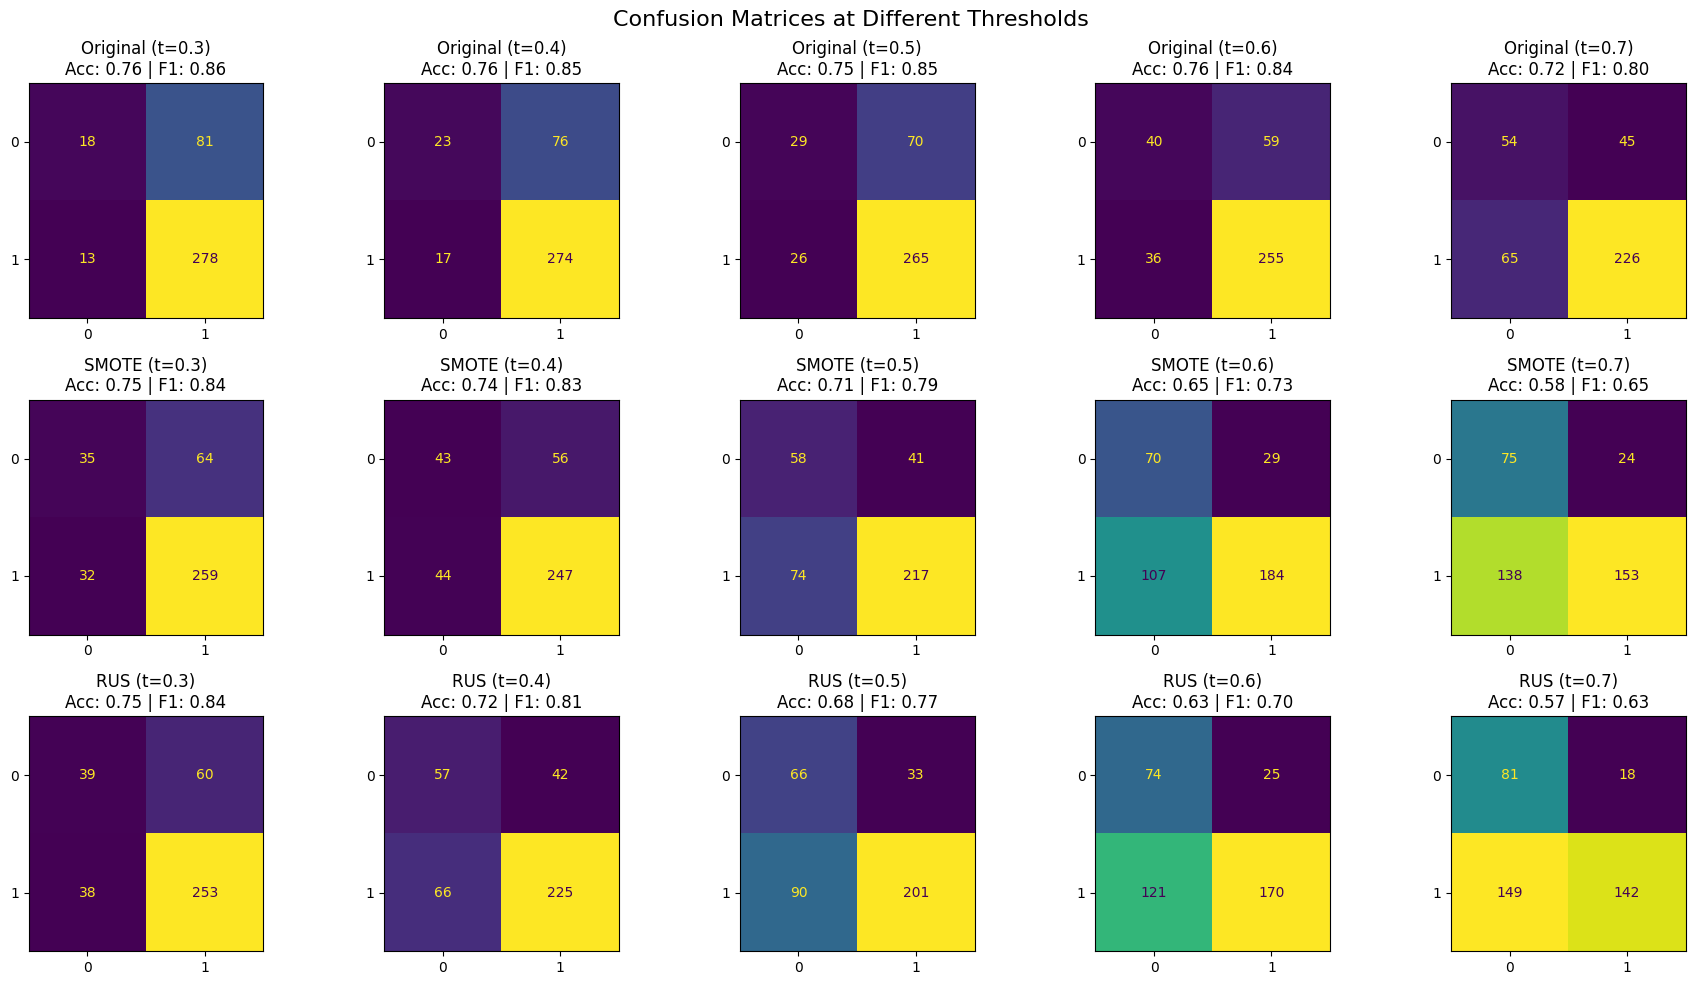

In [ ]:
from sklearn.metrics import accuracy_score

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

models = {
    "Original": best_model,
    "SMOTE": best_model_smote,
    "RUS": best_model_rus
}

fig, axs = plt.subplots(len(models), len(thresholds), figsize=(18, 10))
fig.suptitle("Confusion Matrices at Different Thresholds", fontsize=16)

for row_idx, (label, model) in enumerate(models.items()):
    y_probs = model.predict(test_df[features])
    for col_idx, thresh in enumerate(thresholds):
        y_pred = (y_probs > thresh).astype(int)
        cm = confusion_matrix(test_df['isAlive'], y_pred)

        # Calcute F1 and Accuracy for these threshold
        acc = accuracy_score(test_df['isAlive'], y_pred)
        f1 = f1_score(test_df['isAlive'], y_pred)

        # Display the Confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axs[row_idx, col_idx], colorbar=False)
        axs[row_idx, col_idx].set_title(f"{label} (t={thresh})\nAcc: {acc:.2f} | F1: {f1:.2f}")
        axs[row_idx, col_idx].set_xlabel("")
        axs[row_idx, col_idx].set_ylabel("")

plt.tight_layout()
plt.show()


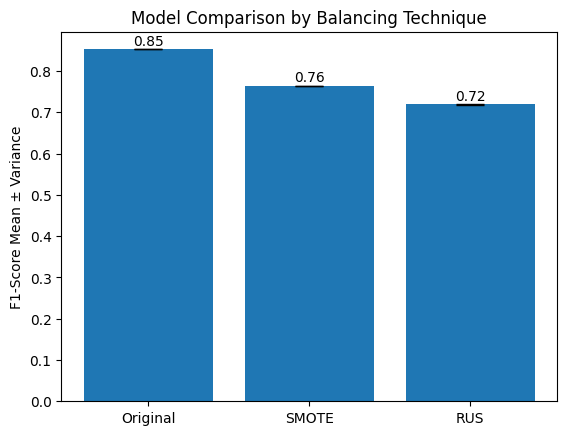

In [ ]:
labels = ['Original', 'SMOTE', 'RUS']
f1_means = [np.mean(original_f1s), np.mean(smote_f1s), np.mean(rus_f1s)]
f1_vars = [np.var(original_f1s), np.var(smote_f1s), np.var(rus_f1s)]

plt.bar(labels, f1_means, yerr=f1_vars, capsize=10)
plt.ylabel('F1-Score Mean ± Variance')
plt.title('Model Comparison by Balancing Technique')

# Display numerical values above each bar
for i in range(len(labels)):
    plt.text(i, f1_means[i] + 0.01, f"{f1_means[i]:.2f}", ha='center')

plt.show()

In [ ]:
summary_df = pd.DataFrame({
    'Model': ['Original', 'SMOTE', 'RUS'],
    'F1 Mean': [np.mean(original_f1s), np.mean(smote_f1s), np.mean(rus_f1s)],
    'F1 Variance': [np.var(original_f1s), np.var(smote_f1s), np.var(rus_f1s)]
})

print(summary_df)


      Model   F1 Mean  F1 Variance
0  Original  0.852491     0.000030
1     SMOTE  0.764519     0.000086
2       RUS  0.719033     0.000514


In [ ]:
from sklearn.metrics import accuracy_score

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
models = {
    "Original": best_model,
    "SMOTE": best_model_smote,
    "RUS": best_model_rus
}

# Array to save the results
results = []

# We calculate the accuracy and f1-score for each combination
for label, model in models.items():
    y_probs = model.predict(test_df[features])
    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)
        acc = accuracy_score(test_df['isAlive'], y_pred)
        f1 = f1_score(test_df['isAlive'], y_pred)
        results.append({
            'Threshold': thresh,
            'Model': label,
            'Accuracy': acc,
            'F1-Score': f1
        })

threshold_df = pd.DataFrame(results)


print(threshold_df)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
    Threshold     Model  Accuracy  F1-Score
0         0.3  Original  0.758974  0.855385
1         0.4  Original  0.761538  0.854914
2         0.5  Original  0.753846  0.846645
3         0.6  Original  0.756410  0.842975
4         0.7  Original  0.717949  0.804270
5         0.3     SMOTE  0.753846  0.843648
6         0.4     SMOTE  0.743590  0.831650
7         0.5     SMOTE  0.705128  0.790528
8         0.6     SMOTE  0.651282  0.730159
9         0.7     SMOTE  0.584615  0.653846
10        0.3       RUS  0.748718  0.837748
11        0.4       RUS  0.723077  0.806452
12        0.5       RUS  0.684615  0.765714
13        0.6       RUS  0.625641  0.699588
14        0.7       RUS  0.571795  0.629712


In [ ]:
dny_pred_best = best_overall_model.predict(test_df[features])
predictions_best = np.where(y_pred_best > 0.5, 1, 0)

print(classification_report(test_df['isAlive'], predictions_best))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.53      0.29      0.38        99
           1       0.79      0.91      0.85       291

    accuracy                           0.75       390
   macro avg       0.66      0.60      0.61       390
weighted avg       0.72      0.75      0.73       390



#Step 3 - Evaluation & questions

#Predict which is the character with more probabilities of death from the test set.

In [ ]:
test_df = pd.read_csv('got_test.csv')

# We make predictions using the best model
X_test = test_df[features]
y_pred = best_overall_model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# We add predictions to the DataFrame
test_df['death_prob'] = y_pred

# We find the character with the highest death probability
most_likely_to_die = test_df.loc[test_df['death_prob'].idxmax()]

print(f"Character most likely to die: {most_likely_to_die['name']}")
print(f"Predicted death probability: {most_likely_to_die['death_prob']}")

Character most likely to die: Olene Tyrell
Predicted death probability: 0.9985078573226929


In [ ]:
olene_info = test_df[test_df['name'] == 'Olene Tyrell']
print(olene_info.T)


                            109
S.No                        824
actual                        1
pred                          1
alive                     0.925
plod                      0.075
name               Olene Tyrell
title                       NaN
male                        0.0
culture                     NaN
dateOfBirth                 NaN
DateoFdeath                 NaN
mother                      NaN
father                      NaN
heir                        NaN
house              House Tyrell
spouse             Leo Blackbar
book1                       0.0
book2                       0.0
book3                       1.0
book4                       1.0
book5                       0.0
isAliveMother               NaN
isAliveFather               NaN
isAliveHeir                 NaN
isAliveSpouse               1.0
isMarried                   1.0
isNoble                     0.0
age                         NaN
numDeadRelations            0.0
boolDeadRelations             0
isPopula

Draw the network architecture used to generate your best model and specify the optimizer, the number of neurons in the hidden layer, and the activation and error functions used. Additionally, report the final error values for both the training set and the validation set.

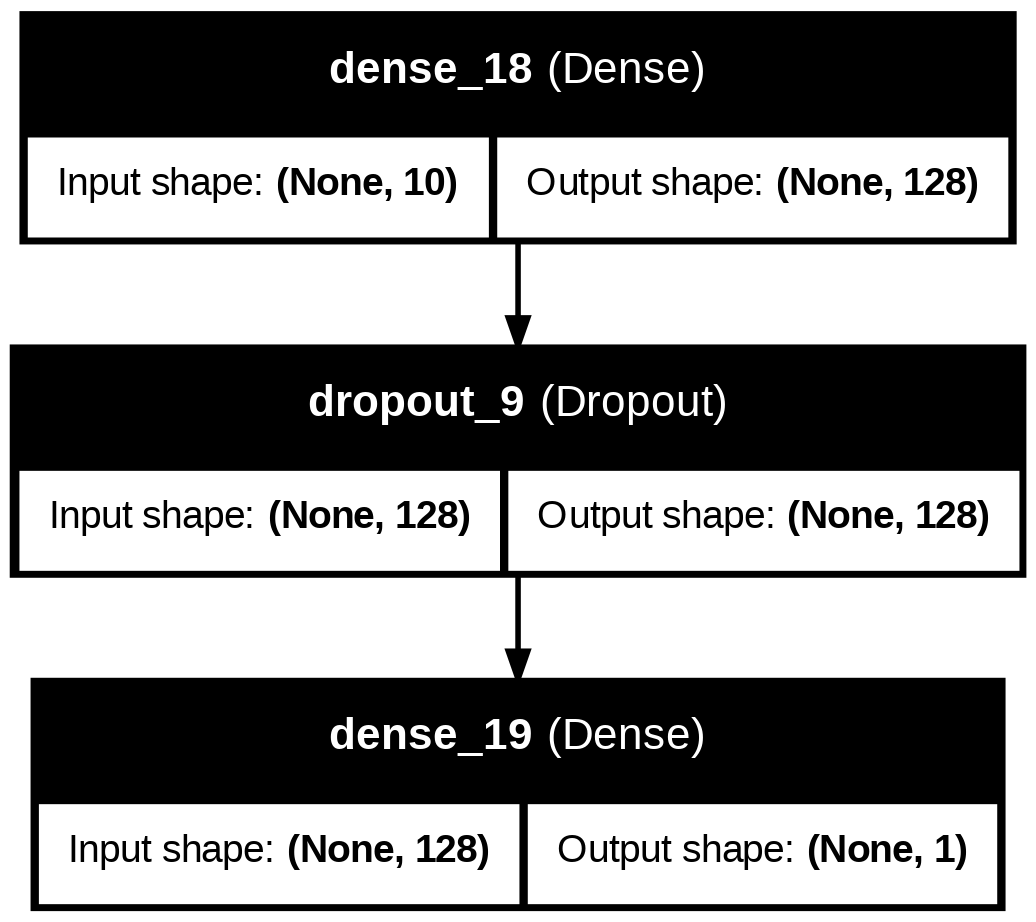

In [ ]:
"""
https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

"""
plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print(f"\nBest Model Configuration:")
print(f"Hidden Neurons: {best_overall_model.layers[0].units}, {best_overall_model.layers[2].units}")
print(f"Optimizer: {type(best_overall_model.optimizer).__name__}")
print(f"Learning Rate: {best_overall_model.optimizer.learning_rate.numpy()}")



print(f"Training Loss: {best_history.history['loss'][-1]}")

print(f"Activation Function (Hidden Layers): ReLU")
print(f"Activation Function (Output Layer): Sigmoid")
print(f"Validation Loss: {best_history.history['val_loss'][-1]}")
print(f"Error Function (Loss Function): Binary Cross-entropy")


Best Model Configuration:
Hidden Neurons: 128, 1
Optimizer: Adam
Learning Rate: 0.0024999999441206455
Training Loss: 0.40876272320747375
Activation Function (Hidden Layers): ReLU
Activation Function (Output Layer): Sigmoid
Validation Loss: 0.5085566639900208
Error Function (Loss Function): Binary Cross-entropy


##Predict the isAlive probability for the characters listed in your test set:


###Identify the character with the highest probability of dying.

In [ ]:
test_df = pd.read_csv('got_test.csv')

# We make predictions using the best model
X_test = test_df[features]
y_pred = best_overall_model.predict(X_test)


test_df['death_prob'] = y_pred

# We find the character with the highest death probability
most_likely_to_die = test_df.loc[test_df['death_prob'].idxmax()]

print(f"Character most likely to die: {most_likely_to_die['name']}")
print(f"Predicted death probability: {most_likely_to_die['death_prob']}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Character most likely to die: Olene Tyrell
Predicted death probability: 0.9985078573226929


###Calculate the error for this prediction

In [ ]:
actual_outcome = most_likely_to_die['isAlive']
prediction_error = abs(actual_outcome - most_likely_to_die['death_prob'])

print(f"Prediction error for {most_likely_to_die['name']}: {prediction_error}")

Prediction error for Olene Tyrell: 0.001492142677307129


### Compare prediction error to validation error

In [ ]:
print(f"Best Model Validation Loss: {best_val_loss}")

Best Model Validation Loss: 0.4823657274246216


Adjust the predictions so that a different character is identified as the one most likely to die:

Describe the specific changes you made to the test set. Justify your changes from the perspective of MLP.

Are all input features equally significant? Explain how you can demonstrate their relative importance.

In [ ]:
test_df = pd.read_csv('got_test.csv')

test_df

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,966,1,1,0.800,0.200,Creighton Redfort,Ser,0.0,Valemen,NaN,...,NaN,NaN,0.0,1.0,NaN,0.000000,0,0.0,0.023411,1
1,507,1,0,0.058,0.942,Euron Greyjoy,NaN,1.0,Ironborn,NaN,...,NaN,NaN,0.0,0.0,NaN,0.266667,1,1.0,0.739130,1
2,1498,1,1,0.985,0.015,Ebrose,Archmaester,1.0,NaN,NaN,...,NaN,NaN,0.0,1.0,NaN,0.000000,0,0.0,0.016722,1
3,937,1,0,0.488,0.512,Bethany Redwyne,Goldengrove,0.0,NaN,NaN,...,NaN,1.0,1.0,1.0,NaN,0.000000,0,0.0,0.060201,1
4,560,1,1,0.959,0.041,Gwin Goodbrother,NaN,0.0,Ironborn,NaN,...,NaN,NaN,0.0,0.0,NaN,0.000000,0,0.0,0.026756,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,45,1,1,0.809,0.191,Zei,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,0.000000,0,0.0,0.013378,1
386,1620,0,0,0.041,0.959,Addam Velaryon,Ser,1.0,Valyrian,114.0,...,NaN,NaN,0.0,1.0,16.0,0.000000,0,0.0,0.107023,0
387,1697,1,1,0.899,0.101,Eustace Osgrey,Knight,1.0,NaN,NaN,...,NaN,0.0,1.0,1.0,NaN,0.000000,0,0.0,0.147157,1
388,553,1,0,0.293,0.707,Grisella,NaN,0.0,Free Folk,NaN,...,NaN,NaN,0.0,0.0,NaN,0.000000,0,0.0,0.010033,1


In [ ]:
# Lower the death probability for the current most likely character
current_top = test_df.loc[test_df['death_prob'].idxmax()]
top_index = test_df[test_df['name'] == current_top['name']].index[0]
test_df.loc[top_index, 'isPopular'] = 1
test_df.loc[top_index, 'isNoble'] = 1
test_df.loc[top_index, 'numDeadRelations'] = 0
test_df.loc[top_index, 'book1'] = 1
test_df.loc[top_index, 'book2'] = 1
test_df.loc[top_index, 'book5'] = 1

# Raise the death probability for another character (not the current top)
alt_name = 'Aeron Greyjoy'
alt_index = test_df[test_df['name'] == alt_name].index[0]
test_df.loc[alt_index, 'isPopular'] = 0
test_df.loc[alt_index, 'isNoble'] = 0
test_df.loc[alt_index, 'numDeadRelations'] = 100
test_df.loc[alt_index, 'book1'] = 0
test_df.loc[alt_index, 'book2'] = 0
test_df.loc[alt_index, 'book3'] = 1
test_df.loc[alt_index, 'book4'] = 1
test_df.loc[alt_index, 'book5'] = 0

# Make new predictions using the updated features
X_test_modified = test_df[features]
y_pred_modified = best_overall_model.predict(X_test_modified)
test_df['death_prob'] = y_pred_modified

# Find the new most likely character to die
most_likely_to_die_modified = test_df.loc[test_df['death_prob'].idxmax()]
print(f"Character most likely to die (modified): {most_likely_to_die_modified['name']}")
print(f"Predicted death probability (modified): {most_likely_to_die_modified['death_prob']}")



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Character most likely to die (modified): Jeyne Lydden
Predicted death probability (modified): 0.9941170811653137
